AIN 442 - Practicum in Natural Language Processing - Assignment 5\
Yusuf Emir Cömert\
2220765023


Making Necessary Imports And Checking If gpu available for training

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score
from transformers import BertTokenizer,BertForSequenceClassification, Trainer, TrainingArguments
import torch
from datasets import Dataset
import seaborn as sns
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertForSequenceClassification
from torch.optim import AdamW, SGD
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
import requests
import json
import re

import torch
print(torch.cuda.is_available())         # True/False
print(torch.cuda.get_device_name(0))     # E.g. Tesla T4


True
Tesla T4


Connecting it to the drive to save the model.

In [13]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Selecting the device for faster computation

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Read the dataset and split it into training and testing sets(already splitted).

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.head()


,text,label
0,"U.S. Strikes Zarqawi Network, Killing 15 BAGHD...",0
1,MGM shares jump 7.5 pct; report suggests deal ...,2
2,Logitech launches laser-tracking mouse SAN FRA...,3
3,Orb Unveils New Service for Digital Media (AP)...,3
4,"Norwegian police hunt for motive, robbers in M...",0


### EDA (Exploratory Data Analysis)

Making Analyses to understand about data.

1- Examining Class Distributions. 

<ipython-input-16-5384cd7bb376>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='label', data=train_df, palette='pastel')


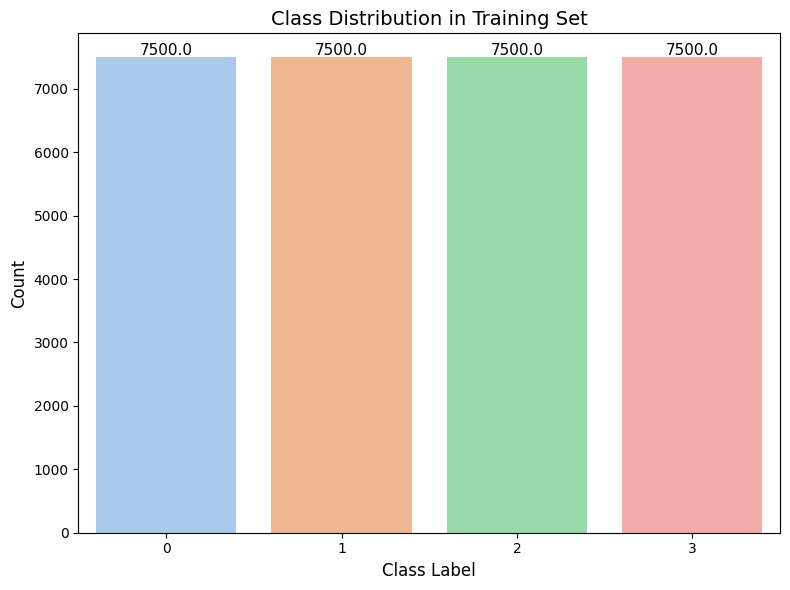

In [ ]:
# Plot: Class Distribution
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='label', data=train_df, palette='pastel')
plt.title('Class Distribution in Training Set', fontsize=14)
plt.xlabel('Class Label', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Add count labels on top of bars
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.tight_layout()
plt.show()

As we can see Classes are perfectly disributed which is a good thing when training the model.

2- Examining the Text Length Distributions.

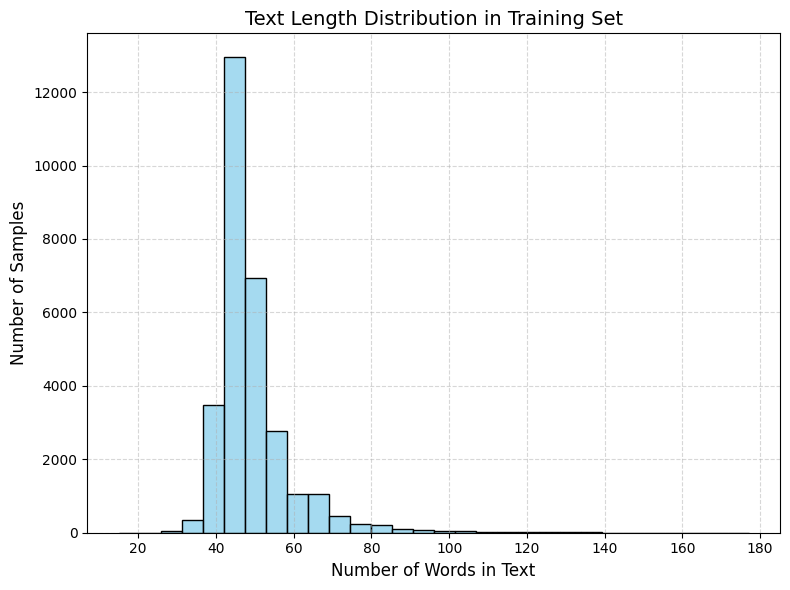

In [17]:
# Calculate text length
train_df['text_length'] = train_df['text'].apply(lambda x: len(x.split()))

# Plot: Text Length Distribution
plt.figure(figsize=(8, 6))
sns.histplot(train_df['text_length'], bins=30, kde=False, color='skyblue')
plt.title('Text Length Distribution in Training Set', fontsize=14)
plt.xlabel('Number of Words in Text', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


As we can see, The mode of this train data is 45 words Length. 

Choosing tokenizer as Bert Base Uncased as asked.

In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Tokenizing the Train data with previously defined tokenizer.

In [ ]:
# Tokenize the Train set
train_encodings = tokenizer(
    train_df['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors='pt'
)

Preaparing the dataset and labels, Also using the DataLoader with 32 Batch Size.

In [ ]:

# Convert labels to tensor
train_labels = torch.tensor(train_df['label'].tolist())

# Create TensorDataset 
train_dataset = TensorDataset(
    train_encodings['input_ids'],
    train_encodings['attention_mask'],
    train_labels
)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

-Fine-Tuning BERT with Different Learning Rates(Hyperparameters Training)

In this section, we fine-tune the BERT Base Uncased model using three different learning rates: 1e-5, 2e-5, and 5e-5. For each learning rate, the model trained for 5 epochs on the training set. During training, we monitor the loss and optimize the model parameters using the AdamW optimizer. After each training run, the model and tokenizer are saved in separate directories for later evaluation and comparison.

Note: I trained the model with SGD, not AdamW, and the first time I trained it it gave high losses, so I removed the SGD optimizer as a parameter to try it out.

In [ ]:

learning_rates = [1e-5, 2e-5, 5e-5]
epochs = 5

for lr in learning_rates:
    print("="*60)
    print(f"Training with learning rate = {lr}")
    print("="*60)

    # Load the model for every learning rate.
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=4)
    model.to(device)

    optimizer = AdamW(model.parameters(), lr=lr)

    model.train()
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        total_loss = 0
        loop = tqdm(train_loader, leave=True)
        for batch in loop:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            loop.set_description(f"Epoch {epoch+1}")
            loop.set_postfix(loss=loss.item())

        print(f"Average training loss (lr={lr}): {total_loss / len(train_loader):.4f}")

    # Save the model.
    model_dir = f"bert_model_lr_{str(lr).replace('.', '')}"
    model.save_pretrained(model_dir)
    tokenizer.save_pretrained(model_dir)

Training with learning rate = 1e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Epoch 1: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.322]


Average training loss (lr=1e-05): 0.3042
Epoch 2/5


Epoch 2: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.384]


Average training loss (lr=1e-05): 0.1349
Epoch 3/5


Epoch 3: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.0254]


Average training loss (lr=1e-05): 0.0930
Epoch 4/5


Epoch 4: 100%|██████████| 938/938 [21:32<00:00,  1.38s/it, loss=0.00156]


Average training loss (lr=1e-05): 0.0630
Epoch 5/5


Epoch 5: 100%|██████████| 938/938 [21:32<00:00,  1.38s/it, loss=0.0568]


Average training loss (lr=1e-05): 0.0414
Training with learning rate = 2e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Epoch 1: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.115]


Average training loss (lr=2e-05): 0.2469
Epoch 2/5


Epoch 2: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.058]


Average training loss (lr=2e-05): 0.1150
Epoch 3/5


Epoch 3: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.0651]


Average training loss (lr=2e-05): 0.0738
Epoch 4/5


Epoch 4: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.00553]


Average training loss (lr=2e-05): 0.0448
Epoch 5/5


Epoch 5: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.00111]


Average training loss (lr=2e-05): 0.0297
Training with learning rate = 5e-05


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5


Epoch 1: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.138]


Average training loss (lr=5e-05): 0.2332
Epoch 2/5


Epoch 2: 100%|██████████| 938/938 [21:32<00:00,  1.38s/it, loss=0.0315]


Average training loss (lr=5e-05): 0.1204
Epoch 3/5


Epoch 3: 100%|██████████| 938/938 [21:32<00:00,  1.38s/it, loss=0.412]


Average training loss (lr=5e-05): 0.0797
Epoch 4/5


Epoch 4: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.0157]


Average training loss (lr=5e-05): 0.0496
Epoch 5/5


Epoch 5: 100%|██████████| 938/938 [21:31<00:00,  1.38s/it, loss=0.0806]


Average training loss (lr=5e-05): 0.0410


Raw texts and labels are extracted from test_df. The texts are then tokenized using the same BERT tokenizer with truncation and padding enabled, ensuring that each sequence has a maximum length of 256 tokens. The resulting tokenized inputs are converted into PyTorch tensors and wrapped in a TensorDataset, which is then loaded into a DataLoader with a batch size of 32.

In [ ]:
# Encoding the test set
test_texts = test_df['text'].tolist()
test_labels = test_df['label'].tolist()
test_encodings = tokenizer(
    test_texts,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors='pt'
)

test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'])
test_loader = DataLoader(test_dataset, batch_size=32)


### Evaluating Results.

For each learning rate, the corresponding trained model and tokenizer are loaded from Google Drive. The model is used to make predictions on the test set in evaluation mode. Predictions are collected in batches and converted to NumPy arrays. The macro-averaged F1 score is computed and stored in a dictionary for later comparison. Additionally, the first 5 test samples are printed along with their true and predicted labels to illustrate the model’s behavior.

In [ ]:
# Record the F1 scores for each learning rate
f1_scores = {}

for lr in learning_rates:
    print("\n" + "="*60)
    print(f"Evaluating model with learning rate = {lr}")
    print("="*60)

    #  Load the trained model and the tokenizer
    model_dir = f"/content/drive/MyDrive/Colab Notebooks/bert_model_lr_{str(lr).replace('.', '')}"
    model = BertForSequenceClassification.from_pretrained(model_dir)
    model.to(device)
    model.eval()

    preds = []

    with torch.no_grad():
        for batch in test_loader:
            input_ids, attention_mask = [b.to(device) for b in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=1).cpu().numpy()
            preds.extend(batch_preds)

    preds = np.array(preds)
    true_labels = np.array(test_labels)

    f1 = f1_score(true_labels, preds, average='macro')
    f1_scores[lr] = f1

    print(f"\nMacro F1 Score on Test Set (lr={lr}): {f1:.4f}")
    print(classification_report(true_labels, preds))

    # Print out the first 5 samples of predictions
    for i in range(5):
        print(f"Sample {i+1}")
        print(f"Text: {test_texts[i]}")
        print(f"True Label: {true_labels[i]}, Predicted Label: {preds[i]}")
        print("-" * 50)



Evaluating model with learning rate = 1e-05

Macro F1 Score on Test Set (lr=1e-05): 0.9267
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      1900
           1       0.97      0.99      0.98      1900
           2       0.89      0.90      0.89      1900
           3       0.90      0.90      0.90      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600

Sample 1
Text: Fan v Fan: Manchester City-Tottenham Hotspur This weekend Manchester City entertain Spurs, and with last seasons seven-goal FA Cup epic between the two teams still fresh in the memory, entertain could be the operative word.
True Label: 1, Predicted Label: 1
--------------------------------------------------
Sample 2
Text: Paris Tourists Search for Key to 'Da Vinci Code' (Reuters) Reuters - A funny thing happened on the way to the\Mona Lisa. Visitors to t

Final F1 scores.

In [ ]:
# F1 skore summary table
print("\n=== F1 Score Summary Across Learning Rates ===")
for lr, score in f1_scores.items():
    print(f"Learning Rate {lr:<6}: F1 Score = {score:.4f}")


=== F1 Score Summary Across Learning Rates ===
Learning Rate 1e-05 : F1 Score = 0.9267
Learning Rate 2e-05 : F1 Score = 0.9255
Learning Rate 5e-05 : F1 Score = 0.9239


# PART 2: Title and Well-Written Article Generation

The Gemini API key, model name, and API version are specified. The full request URL is constructed using these components. This URL is used to send requests to the Gemini 2.0 Flash model via the Google Generative Language API.

In [ ]:
API_KEY = "ENTER_YOUR_API_KEY_HERE"

model_name = "gemini-2.0-flash"
api_version = "v1beta"
url = f"https://generativelanguage.googleapis.com/{api_version}/models/{model_name}:generateContent?key={API_KEY}"



A structured prompt is defined to instruct the LLM to generate a title and a polished version of a given news article. The prompt enforces a specific output format to simplify parsing. The prompt is sent as a POST request to the Gemini API endpoint. If the response is successful, the generated text is extracted and returned. If an error occurs, it is printed and None is returned.

In [ ]:
# Hocam I took this prompt from AI. Because JSON format should be true.

def generate_title_and_polished_article(text):
    prompt = {
        "contents": [
            {
                "parts": [
                    {
                        "text": f"""
You are an AI editor. Given the following raw news article, generate:

1. A short and clear title.
2. A polished, professionally rewritten version of the article.

Return the result in this format exactly:
Title: <title here>
Article: <polished article here>

ARTICLE:
{text}
                        """
                    }
                ]
            }
        ]
    }

    response = requests.post(url, json=prompt)
    result = response.json()

    try:
        text_response = result['candidates'][0]['content']['parts'][0]['text']
        return text_response
    except:
        print("Error in response:", result)
        return None


Example Result. As it can be seen, Gemini API correctly creates the title.

In [32]:
sample_text = train_df['text'].iloc[0]
response = generate_title_and_polished_article(sample_text)
print(response)


Title: US Strikes Zarqawi Network in Fallujah

Article: U.S. forces launched a series of strikes against Abu Musab al-Zarqawi's terror network in Fallujah on Saturday, utilizing warplanes, tanks, and artillery. The operation occurred amidst efforts by two British Muslim leaders who arrived in Baghdad seeking the release of a British hostage believed to be held by Zarqawi's group. Reports indicate that 15 individuals were killed in the U.S. offensive.



# Part 3: Combining 2 Tasks

A dictionary is defined to map numeric class labels to their corresponding category names. An empty list is initialized to store the final output dictionaries containing the category, title, and polished article for each sample.

In [33]:
category_map = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

results = []


The last five articles from the training set are selected as specified. These samples are tokenized using the BERT tokenizer with truncation and padding applied. The resulting tensors are transferred to the appropriate device (CPU or GPU) for inference.

In [ ]:
# Last 5 Articles from the training set as asked.
sample_texts = train_df['text'].tail(5).tolist()

# Tokenize and sent to the model
sample_inputs = tokenizer(
    sample_texts,
    truncation=True,
    padding=True,
    max_length=256,
    return_tensors='pt'
)

sample_inputs = {k: v.to(device) for k, v in sample_inputs.items()}

Extract the Required parts of the output with this parse_response function.

In [ ]:
def parse_response(text_response):
    match = re.search(r"Title:\s*(.*?)\n+Article:\s*(.*)", text_response, re.DOTALL)
    if match:
        return {
            "title": match.group(1).strip(),
            "article": match.group(2).strip()
        }
    else:
        return {"title": None, "article": None}


First, Load the best model and predict the categories with that pretrained model.\
 Then, from using Gemini, request Title and Article, \
 Lastly  parse it and store it in the result dictionary.

In [ ]:
# Predict the categories for the last 5 articles

# But First, Load the best model (you can choose the one with the highest F1 score)
model_dir = "/content/drive/MyDrive/Colab Notebooks/bert_model_lr_1e5"
model = BertForSequenceClassification.from_pretrained(model_dir)
tokenizer = BertTokenizer.from_pretrained(model_dir)
model.to(device)
model.eval()

with torch.no_grad():
    outputs = model(**sample_inputs)
    logits = outputs.logits
    preds = torch.argmax(logits, dim=1).cpu().tolist()

# Pull title + article from Gemini for each instance
for text, pred_label in zip(sample_texts, preds):
    response_text = generate_title_and_polished_article(text)
    parsed = parse_response(response_text)

    result = {
        "category": category_map[pred_label],
        "title": parsed.get("title"),
        "article": parsed.get("article")
    }

    results.append(result)

Print Out the Last 5 samples. in the correct format.

In [ ]:
# Print the results.
for i, res in enumerate(results, 1):
    print(f"Sample {i}")
    print(json.dumps(res, indent=2))
    print("-" * 60)

Sample 1
{
  "category": "Sci/Tech",
  "title": "Orangutans Azy and Indah Arrive at Education Center",
  "article": "Azy and Indah, two orangutans, have arrived at the Education Center after a journey that included braving a hurricane. The pair were escorted to their new home in a procession befitting dignitaries, complete with a police escort and flashing lights."
}
------------------------------------------------------------
Sample 2
{
  "category": "World",
  "title": "US Army Deserter Jenkins Arrives in Japan",
  "article": "Robert Jenkins, a former U.S. Army soldier who deserted to North Korea nearly four decades ago, arrived in his wife's hometown on a remote island in northern Japan on Tuesday. He was met by cheering crowds and stated his intention to spend his \"remaining days\" there. Jenkins, originally from North Carolina, is expected to settle in Japan with his family."
}
------------------------------------------------------------
Sample 3
{
  "category": "World",
  "title

# Results:

To assess the impact of different learning rates on model performance, three separate BERT fine-tuning experiments were conducted using learning rates of 1e-5, 2e-5, and 5e-5. Each model was trained for 5 epochs on the training set using the same architecture and optimizer settings. The only variable changed across runs was the learning rate.

After training, the models were evaluated on a fixed test set using the macro-averaged F1 score, which equally weighs performance across all four classes. This metric provides a balanced view of classification quality, especially in multi-class settings.

The following table summarizes the results:

=== F1 Score Summary Across Learning Rates ===\
Learning Rate 1e-05 : F1 Score = 0.9267\
Learning Rate 2e-05 : F1 Score = 0.9255\
Learning Rate 5e-05 : F1 Score = 0.9239


The best performance was achieved using a learning rate of 1e-5, with a macro F1 score of 0.9267. This model was selected for the final pipeline.

In the final step, the last five articles from the training set were processed end-to-end. Each article was:

- Tokenized and classified using the best-performing BERT model.
- Passed to a Gemini LLM via API to generate a short and informative title.
- Rewritten into a more polished article version using the same LLM.

The final outputs were formatted as a list of dictionaries, with each dictionary containing the following keys:
- "category": The predicted class label as a string (e.g., "World", "Sports").
- "title": The generated article title.
- "article": The rewritten, polished version of the article.